In [6]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import fobs
from gwo import Grey_Wolf_Optimizer

In [7]:
# Definindo os parâmetros do GWO
parametros = {
    'funcao': fobs.easom_function,
    'lim': fobs.limit_easom,
    'n_dim': 2,
    'alpha': 0.01,
    'beta': 0.5,
    'delta': 0.1,
    'max_iter': 250,
    'pop_size': 10
}


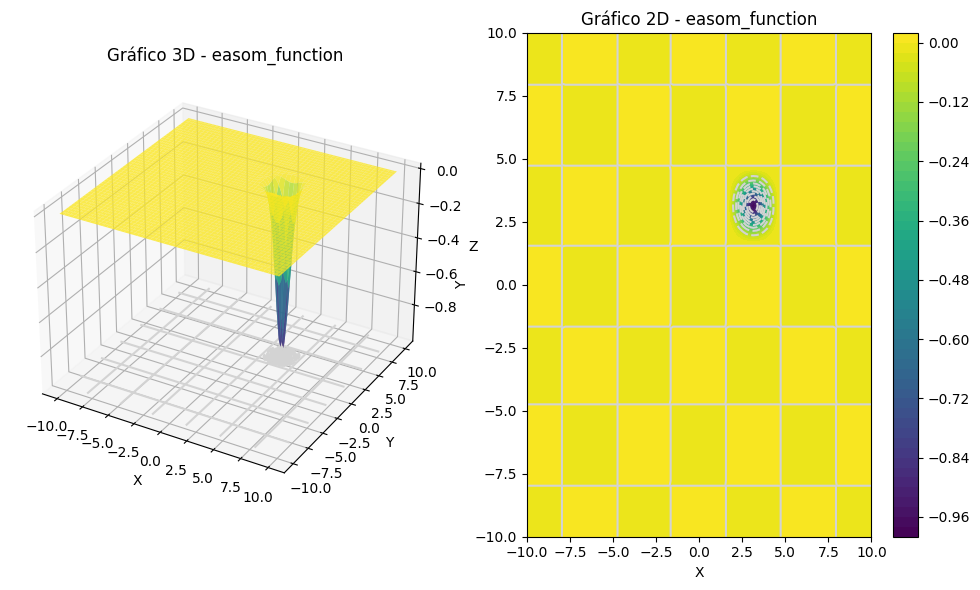

In [8]:
# Criar os pontos no espaço de busca
x_values = np.linspace(parametros['lim'][0, 0], parametros['lim'][0, 1], 100)
y_values = np.linspace(parametros['lim'][1, 0], parametros['lim'][1, 1], 100)
X, Y = np.meshgrid(x_values, y_values)
Z = parametros['funcao'](X, Y)

# Plot 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
ax.contour(X, Y, Z, levels=50, colors='lightgrey', offset=np.min(Z))
ax.set_title('Gráfico 3D - easom_function')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Plot 2D
ax2 = fig.add_subplot(122)
contour = ax2.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.contour(X, Y, Z, colors='lightgrey', levels=10) 
ax2.set_title('Gráfico 2D - easom_function')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')

plt.tight_layout()
plt.show()

In [9]:
num_rodadas = 100
results = []  
hists = []

for _ in range(num_rodadas): 
    gwo = Grey_Wolf_Optimizer(parametros)
    melhor_solucao, melhor_fitness = gwo.run()
    results.append((melhor_solucao[0], melhor_solucao[1], melhor_fitness))
    hists.append(gwo.resultados_fitness)

results = pd.DataFrame(results, columns=['X', 'Y', 'Fitness'])

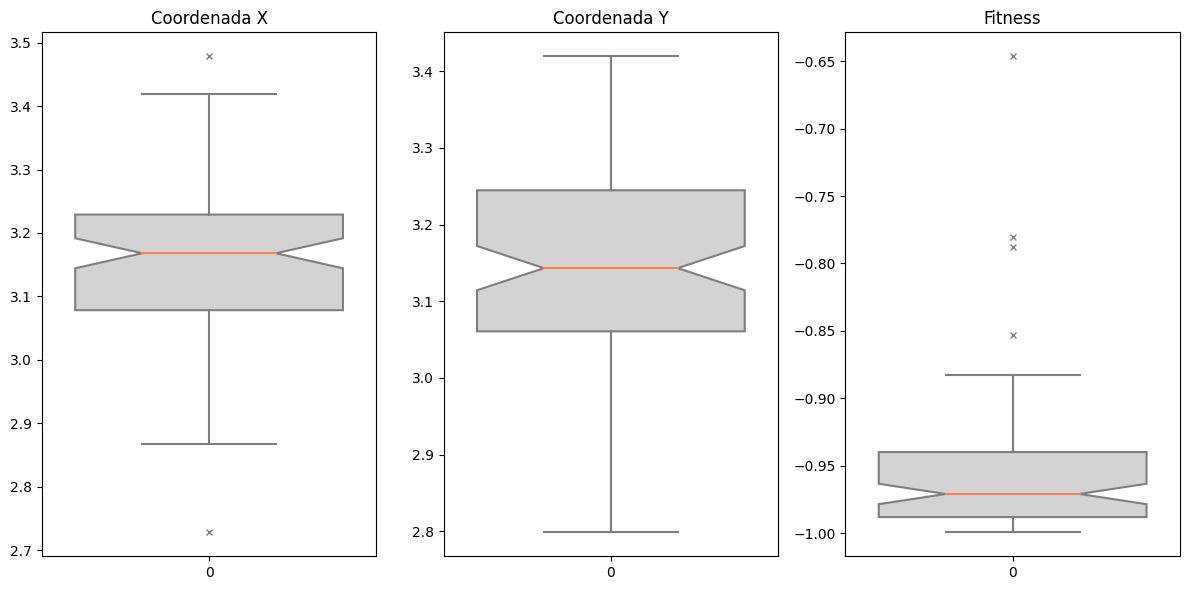

In [10]:
# Criar a figura com três boxplots lado a lado
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# Boxplot para a coluna 'X'
sns.boxplot(
            data=results['X'], 
            color='lightgrey', 
            notch=True, showcaps=True,
            flierprops={"marker": "x"},
            medianprops={"color": "coral"},
            ax=axs[0])
axs[0].set_title('Coordenada X')

# Boxplot para a coluna 'Y'
sns.boxplot(data=results['Y'], 
            color='lightgrey', 
            notch=True, showcaps=True,
            flierprops={"marker": "x"},
            medianprops={"color": "coral"}, 
            ax=axs[1])
axs[1].set_title('Coordenada Y')

# Boxplot para a coluna 'Fitness'
sns.boxplot(data=results['Fitness'], 
            color='lightgrey',  
            notch=True, showcaps=True,
            flierprops={"marker": "x"},
            medianprops={"color": "coral"}, 
            ax=axs[2])
axs[2].set_title('Fitness')


plt.tight_layout()
plt.show()

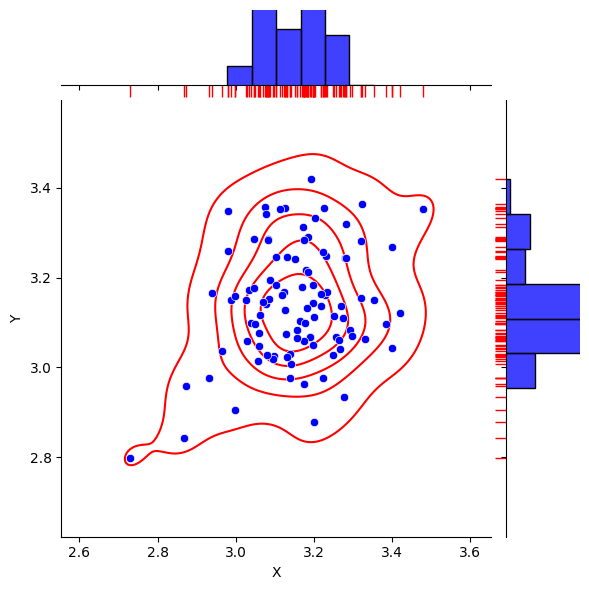

In [11]:
g = sns.jointplot(data=results, x="X", y="Y", color='blue')
g.plot_joint(sns.kdeplot, color="red", zorder=0, levels=6)
g.plot_marginals(sns.rugplot, color="red", height=-.15, clip_on=False)

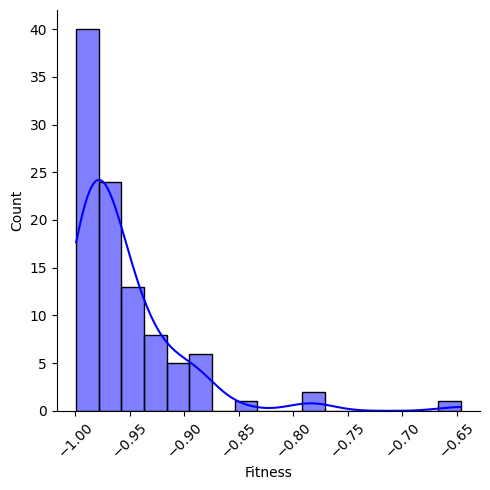

In [12]:
# Criar o displot com kde e deixar que o Seaborn utilize a paleta definida
sns.displot(data=results, x="Fitness", kde=True, color='blue')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

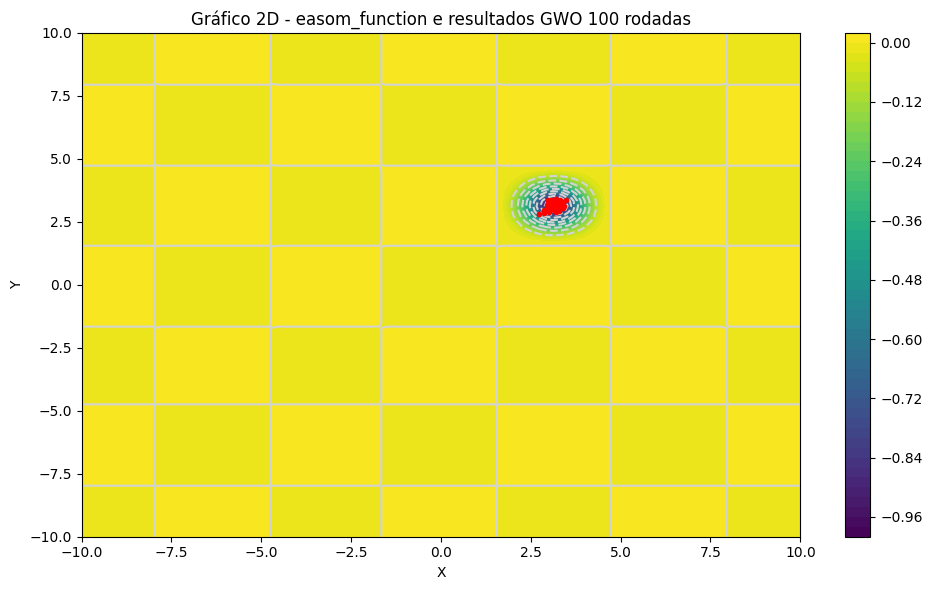

In [13]:
# Plot 2D e gráfico de dispersão com KDE no mesmo gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 2D com contourf
contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.contour(X, Y, Z, colors='lightgrey', levels=10) 
ax.set_title('Gráfico 2D - easom_function e resultados GWO 100 rodadas')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Gráfico de dispersão com KDE
plt.plot(results['X'],results['Y'],'.',color='red')

# Mostrar o gráfico
plt.tight_layout()
plt.show()

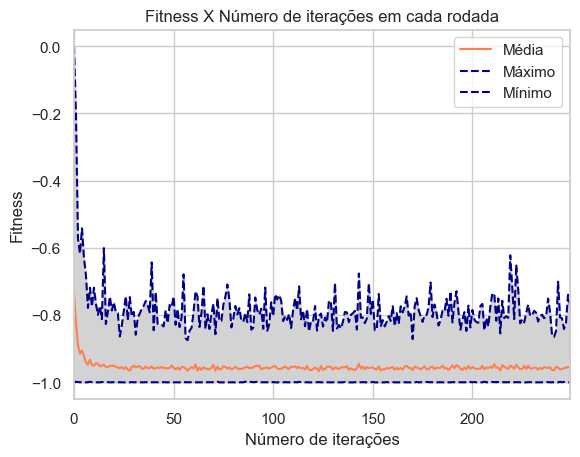

In [14]:
# Converter o vetor de vetores em um DataFrame para facilitar a plotagem
df_hists = pd.DataFrame(hists).T

# Calcular a média, máximo e mínimo do DataFrame
media = df_hists.mean(axis=1)
maximo = df_hists.max(axis=1)
minimo = df_hists.min(axis=1)

# Definir o estilo do Seaborn com a paleta de cores azuis
sns.set(style="whitegrid", palette="Blues")

# Criar o gráfico de linhas com as estatísticas (média, máximo e mínimo)
ax = media.plot.line(color='coral', label='Média')
ax.plot(df_hists.index, maximo, color='darkblue', linestyle='--', label='Máximo')
ax.plot(df_hists.index, minimo, color='darkblue', linestyle='--', label='Mínimo')

# Preencher a área entre as linhas de máximo e mínimo com azul claro
ax.fill_between(df_hists.index, minimo, maximo, color='lightgrey')

plt.xlim(0, df_hists.shape[0] - 1)
plt.title('Fitness X Número de iterações em cada rodada')
plt.xlabel('Número de iterações')
plt.ylabel('Fitness')

# Mostrar a legenda com as etiquetas de cada estatística
plt.legend()

# Mostrar o gráfico
plt.show()

In [15]:
def salvar_lista_dataframes_para_json(lista_dataframes, nome_arquivo):
    '''
    Salva a lista de dfs processada em um arquivo json
    '''
    lista_dicionarios = []
    with open(nome_arquivo, 'w') as outfile:
        lista_dicionarios = [df.to_dict() for df in lista_dataframes]
        outfile.write(json.dumps(lista_dicionarios))
    print("Arquivo JSON salvo com sucesso.")
    
def list_dict_to_list_df(list_dict):
    '''
    Transforma uma lista de dicionarios em uma lista de vetores
    Usada para pegar arquivos JSON de multiplos espectros do OSA thorlabs e converter para o formato comum
    '''
    lista_dataframes = []
    for dicionario in list_dict:
        df = pd.DataFrame.from_dict(dicionario)
        lista_dataframes.append(df)
    return(lista_dataframes)

In [16]:
results.to_json(r'C:\MESTRADO\3008021\NOTEBOOKS\AULA5\aruivosJSON\GWO\results_GWO_100_rodadas_easom_function.json')

df_hists.to_json(r'C:\MESTRADO\3008021\NOTEBOOKS\AULA5\aruivosJSON\GWO\df_hists_GWO_100_rodadas_easom_function.json')